# Example: Markov Stability with PyGenStability

This example illustrate how to use pygenstability for multiscale community detection with Markov Stability algorithm.

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

from pygenstability import run, plotting

We first create a stochastic block model graph with some planted partitions.

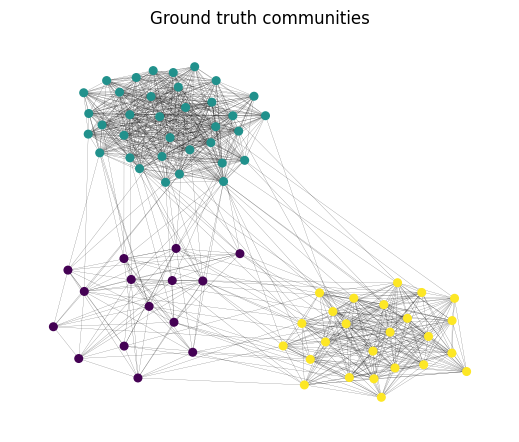

In [13]:
np.random.seed(42)
sizes = [15, 35, 25]
probs = [[0.7, 0.08, 0.10], [0.08, 0.8, 0.02], [0.10, 0.02, 0.80]]

graph = nx.stochastic_block_model(sizes, probs, seed=0)

# need to set the weights to 1
for i, j in graph.edges():
    graph[i][j]["weight"] = 1

# ground truth
community_labels = [graph.nodes[i]["block"] for i in graph]

# spring layout
pos = nx.spring_layout(graph, weight=None, scale=1)
for u in graph:
    graph.nodes[u]["pos"] = pos[u]

# draw the graph with ground truth
plt.figure(figsize=(5, 4))
nx.draw(graph, pos=pos, node_color=community_labels, node_size=30, width=0.1)
plt.title("Ground truth communities")
plt.savefig("ground_truth.png", bbox_inches="tight")

# save adjacency with pickle
adjacency =  nx.to_scipy_sparse_array(graph, weight="weight")
with open("sbm_graph.pkl", "wb") as pickle_file:
    pickle.dump(adjacency, pickle_file)

# save .gpickle for community plotting
nx.write_gpickle(graph, "sbm_graph.gpickle")

# save with text file as alternative format
edges = pd.DataFrame()
edges["i"] = [e[0] for e in graph.edges] + [e[1] for e in graph.edges]
edges["j"] = [e[1] for e in graph.edges] + [e[0] for e in graph.edges]
edges["weight"] = 2 * [graph.edges[e]["weight"] for e in graph.edges]
edges.to_csv("edges.csv", index=False)

We then run pygenstability with the continuous_normalized constructor, which corresponds to using the normalized Laplacian matrix in the Markov Stability.
The number and range of markov times, or scales can be specified with max_scale, min_scale and n_scales. They are in log scale by default.
The number of louvain evaluations is specified with n_tries argument.

Other options are available, see the documentation: https://barahona-research-group.github.io/PyGenStability/

In [46]:
# run Markov Stability
all_results = run(adjacency, constructor='continuous_normalized',
                  min_scale=-1, max_scale=0.5, n_scale=100, n_tries=50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 83.66it/s]


The standard plot to analyse multiscale clustering results in plot_scan, which shows various informations, such as the number of cluster, stability, normalized variation of information (NVI) between Louvain evalutions, and accros scales (NVI(t, t')). Finally, if computed a scale detection algorithm highlights most robust scales.

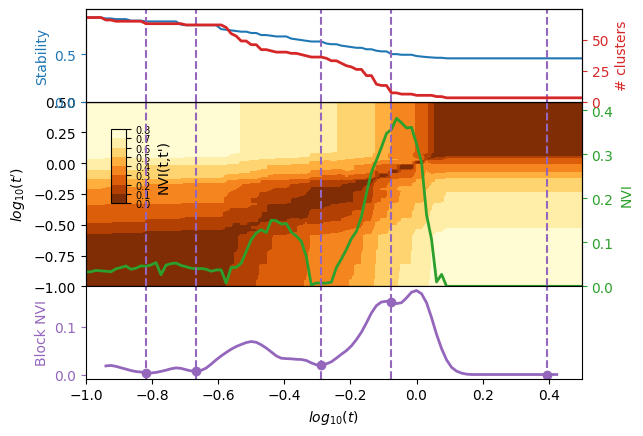

In [47]:
_ = plotting.plot_scan(all_results)

We can then plot some selected partitions from the optimial scale detection algorithm, but here, we expect only one scale to be meaningful. See https://github.com/barahona-research-group/PyGenStability/blob/master/examples/multiscale_example.py for a more complex a multiscale example.

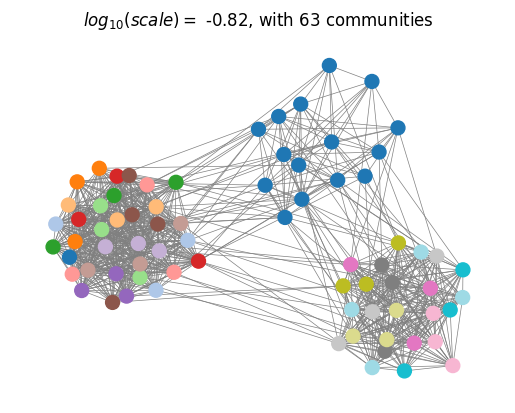

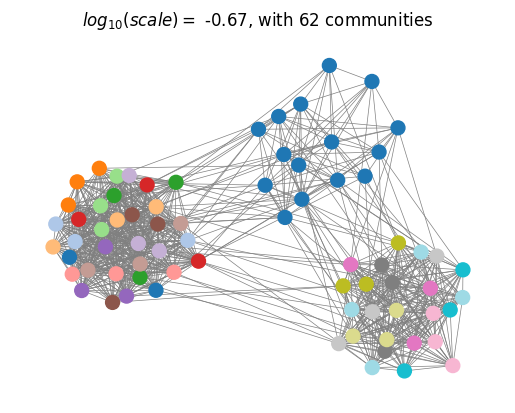

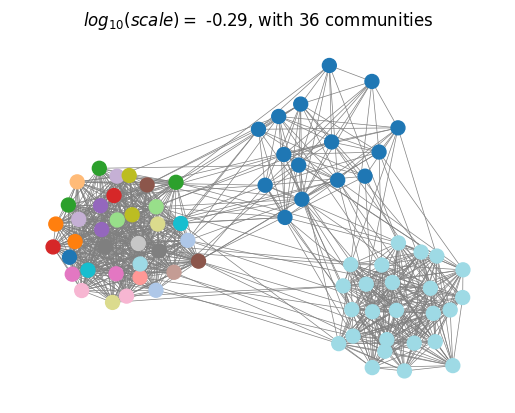

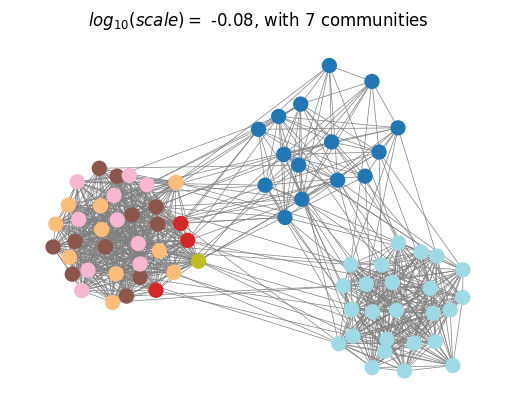

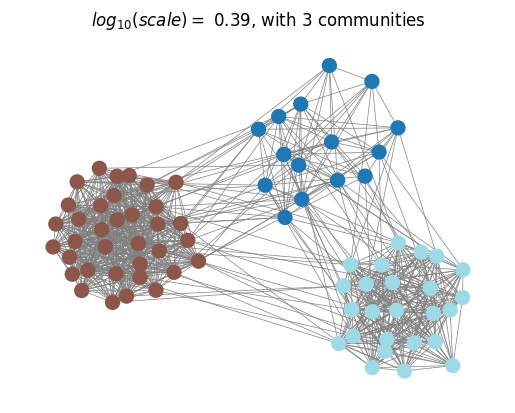

In [48]:
nx_graph = nx.Graph(graph)
pos = nx.spring_layout(nx_graph, weight=None, scale=1)
for u in nx_graph:
    nx_graph.nodes[u]["pos"] = pos[u]
    
for partition in all_results['selected_partitions']:
    plt.figure()
    plotting.plot_single_partition(nx_graph, all_results, partition)